In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from scipy.stats import rankdata
import pandas as pd
import pickle
import lightgbm
import os
from lime import lime_tabular
import sys
sys.path.append('..')
from lirme_v2 import LIRME
from sklearn.utils import shuffle
from scipy.stats import spearmanr, kendalltau
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import sys
sys.path.append('..')
from evaluation import get_fidelity_ltr,validity_completeness,  get_explain_ndcg, validity_completeness, get_infidelity, get_fidelity_ltr, get_dpff, summarize

from get_exp_new import lime_exp, shap_exp, random_exp, grad_exp
from greedy_score import Greedy
from sklearn.metrics import ndcg_score
import seaborn as sns
import matplotlib.pyplot as plt
import os
from pathlib import Path

In [3]:
color_list = {
    #'rank_lime': 'blue',
    'lirme': 'gold',
    'lime': 'darkorange',
    'shap': 'brown',
    'exs_top_k_rank': 'cyan', 
    'exs_top_k_binary': 'lightgreen', 
    'exs_score': 'magenta',
    'random': 'black',
    'pmi': 'turquoise',
    'greedy_score': 'blue',
    'rank_lime': 'green'
}
exp_names_figure = {
    'lime': 'LIME',
    'shap': 'SHAP',
    'lirme': 'LIRME',
    'exs_score': 'EXS (S)',
    'exs_top_k_binary': 'EXS (B)',
    'exs_top_k_rank': 'EXS (R)',
    'pmi': 'PMI',
    'greedy_score': 'Greedy Score',
    'rank_lime': 'RankLIME',
    'random': 'Random',
    'gt': 'GT (Baseline)',
    'ff': 'FF (Baseline)'
}

DATASET_NAME = 'yahoo'

fig, ax = plt.subplots(2, 3, figsize=(15, 8))
ax = ax.ravel()
i = 0
exps_1 = pickle.load( open( f"./result/{DATASET_NAME}_consistency_pointwise_exps_{e_sample_sizes[i]}.p", "rb" ) )
e_s = list(exps_1[18219].keys())
for name, value in enumerate(exps_1[18219].items()):
    sns.heatmap(value[1], ax=ax[name])
    ax[name].set_title(e_s[name])

result = {}

for p in pointwise_exp: 
   result[p] = []

for i in range(len(e_sample_sizes) - 1):
    exps_1 = pickle.load( open( f"./result/{DATASET_NAME}_consistency_pointwise_exps_{e_sample_sizes[i]}.p", "rb" ) )
    exps_2 = pickle.load( open( f"./result/{DATASET_NAME}_consistency_pointwise_exps_{e_sample_sizes[i + 1]}.p", "rb" ) )
    pointwise_exp = ['lime', 'shap', 'lirme', 'exs_score', 'exs_top_k_binary', 'exs_top_k_rank']
        
    for p in pointwise_exp: 
        temp_0 = []
        for key in exps_1.keys():
            temp = []
            for k in range(len(exps_1[key][p])):
                #result[p].append(kendalltau(exps_1[key][p][k], exps_2[key][p][k]).statistic)
                temp.append(kendalltau(exps_1[key][p][k], exps_2[key][p][k]).statistic)
            temp_0.append(np.mean(temp))
        result[p].append(np.mean(temp_0))
for r in result.keys():
    plt.plot([1000, 1500, 2000, 3000, 4000, 5000], result[r], label=r)
plt.legend()

listwise_sample_sizes = [100, 200, 400, 500, 700, 1000, 1500, 2000, 3000]
l_result = {}
listwise_exp = ['rank_lime']

for p in listwise_exp: 
   l_result[p] = []

for i in range(len(listwise_sample_sizes) - 1):
    exps_1 = pickle.load( open( f"./result/{DATASET_NAME}_consistency_listwise_exp_{listwise_sample_sizes[i]}.p", "rb" ) )
    exps_2 = pickle.load( open( f"./result/{DATASET_NAME}_consistency_listwise_exp_{listwise_sample_sizes[i + 1]}.p", "rb" ) )
        
    for p in listwise_exp: 
        temp = []
        for key in exps_1.keys():
            temp.append(kendalltau(exps_1[key][p], exps_2[key][p]).statistic)
        l_result[p].append(np.mean(temp))

### Evaluation with sample size

In [7]:
def evaluate(exps_file, test, model):
    eval = {'dpff': {}, 'fidelity_ltr': {}, 'validity': {}, 'completeness': {}, 'infidelity': {}, 'explain_ndcg': {}}
    #exp_names = ['rank_lime', 'lime', 'shap', 'lirme', 'exs_score', 'exs_top_k_binary', 'exs_top_k_rank']
    measure_keys = ['dpff', 'fidelity_ltr', 'validity', 'completeness', 'infidelity', 'explain_ndcg']
    queries = list(exps_file.keys())
    exp_names = list(exps_file[queries[0]].keys())
    
    for exp_name in exp_names:
        for m in measure_keys:
            eval[m][exp_name] = []
        
    for q_id in exps_file.keys():
        doc_values = test[q_id]
        for exp_name in exp_names:
            exp_val = np.array(exps_file[q_id][exp_name]).flatten()
            
            eval['fidelity_ltr'][exp_name].append(get_fidelity_ltr(exp_val, doc_values, model.predict))
            eval['validity'][exp_name].append(validity_completeness(exp_val, doc_values, model.predict, 'validity'))
            eval['completeness'][exp_name].append(validity_completeness(exp_val, doc_values, model.predict, 'completeness'))
            eval['infidelity'][exp_name].append(get_infidelity(exp_val, doc_values, model.predict, background))
            eval['explain_ndcg'][exp_name].append(get_explain_ndcg(exp_val, doc_values, model.predict))
            eval['fidelity_ltr'][exp_name].append(get_fidelity_ltr(exp_val, doc_values, model.predict))
            eval['dpff'][exp_name].append(get_dpff(exp_val, doc_values, ranker))
    
    summary = summarize(eval)
    summary_df = pd.DataFrame(summary)
    
    return summary_df

In [8]:
def agg(exps):
    res = {}
    for q in exps.keys():
        res[q] = {}
        for p_exp in exps[q]:
            res[q][p_exp] = np.sum(np.array(exps[q][p_exp]), axis=0)
    return res

# Evaluate for all datasets based on sample size

test_sample = pickle.load( open( "../data/{}_test_sample_v2.p".format(DATASET_NAME), "rb" ) )
background_dict = pickle.load( open( "../data/{}_background_v3.p".format(DATASET_NAME), "rb" ) )
e_sample_sizes = [500, 1000, 1500, 2000, 3000, 4000, 5000]
background = []
for q in background_dict:
    background.extend(background_dict[q])
    
background = np.array(background).reshape(-1, test_sample[list(test_sample.keys())[0]].shape[1])
ranker = lightgbm.Booster(model_file='../models/lmart_{}_v2.txt'.format(DATASET_NAME))

result_pointwise = []
pointwise_exp = ['lime', 'shap', 'lirme', 'exs_score', 'exs_top_k_binary', 'exs_top_k_rank']

for i in range(len(e_sample_sizes)):
    exps_pointw = pickle.load( open( f"./result/{DATASET_NAME}_consistency_pointwise_exps_{e_sample_sizes[i]}.p", "rb" ) )
    exps_pointw = agg(exps_pointw)
    eval_result_pointwise = evaluate(exps_pointw, test_sample, ranker)
    result_pointwise.append(eval_result_pointwise)

pickle.dump(result_pointwise, open( f'./pointwise_eval_agg_result_{DATASET_NAME}.p', "wb" ) )

result_listwise = []
listwise_exp = ['rank_lime']
e_listwise_sample_sizes = [400, 500, 700, 1000, 1500, 2000, 3000]

for i in range(len(e_listwise_sample_sizes)):
    exps_listw = pickle.load( open( f"./result/{DATASET_NAME}_consistency_listwise_exp_{e_listwise_sample_sizes[i]}.p", "rb" ) )
    eval_result_list = evaluate(exps_listw, test_sample, ranker)
    result_listwise.append(eval_result_list)

pickle.dump(result_listwise, open( f'./listwise_eval_agg_result_{DATASET_NAME}.p', "wb" ) )

In [103]:
DATASET_NAME = 'yahoo'

In [104]:
#result = np.load(f'./pointwise_eval_agg_result_{DATASET_NAME}.npy')
#result_listwise = np.load(f'./listwise_eval_agg_result_{DATASET_NAME}.npy')
result = pickle.load( open( f'./pointwise_eval_agg_result_{DATASET_NAME}.p', "rb" ) )
result_listwise = pickle.load( open( f'./listwise_eval_agg_result_{DATASET_NAME}.p', "rb" ) )

In [105]:
def process_ax(ax):
    for axis in ['bottom', 'left']:
        ax.spines[axis].set_linewidth(2.5)
        ax.spines[axis].set_color('0.2')

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.tick_params(width = 2.5, color = '0.2')

    ax.set_xlabel(ax.get_xlabel(), fontsize = 15, weight = 'bold', color = '0.2')
    ax.set_ylabel(ax.get_ylabel(), fontsize = 15, weight = 'bold', color = '0.2')

    return ax

FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


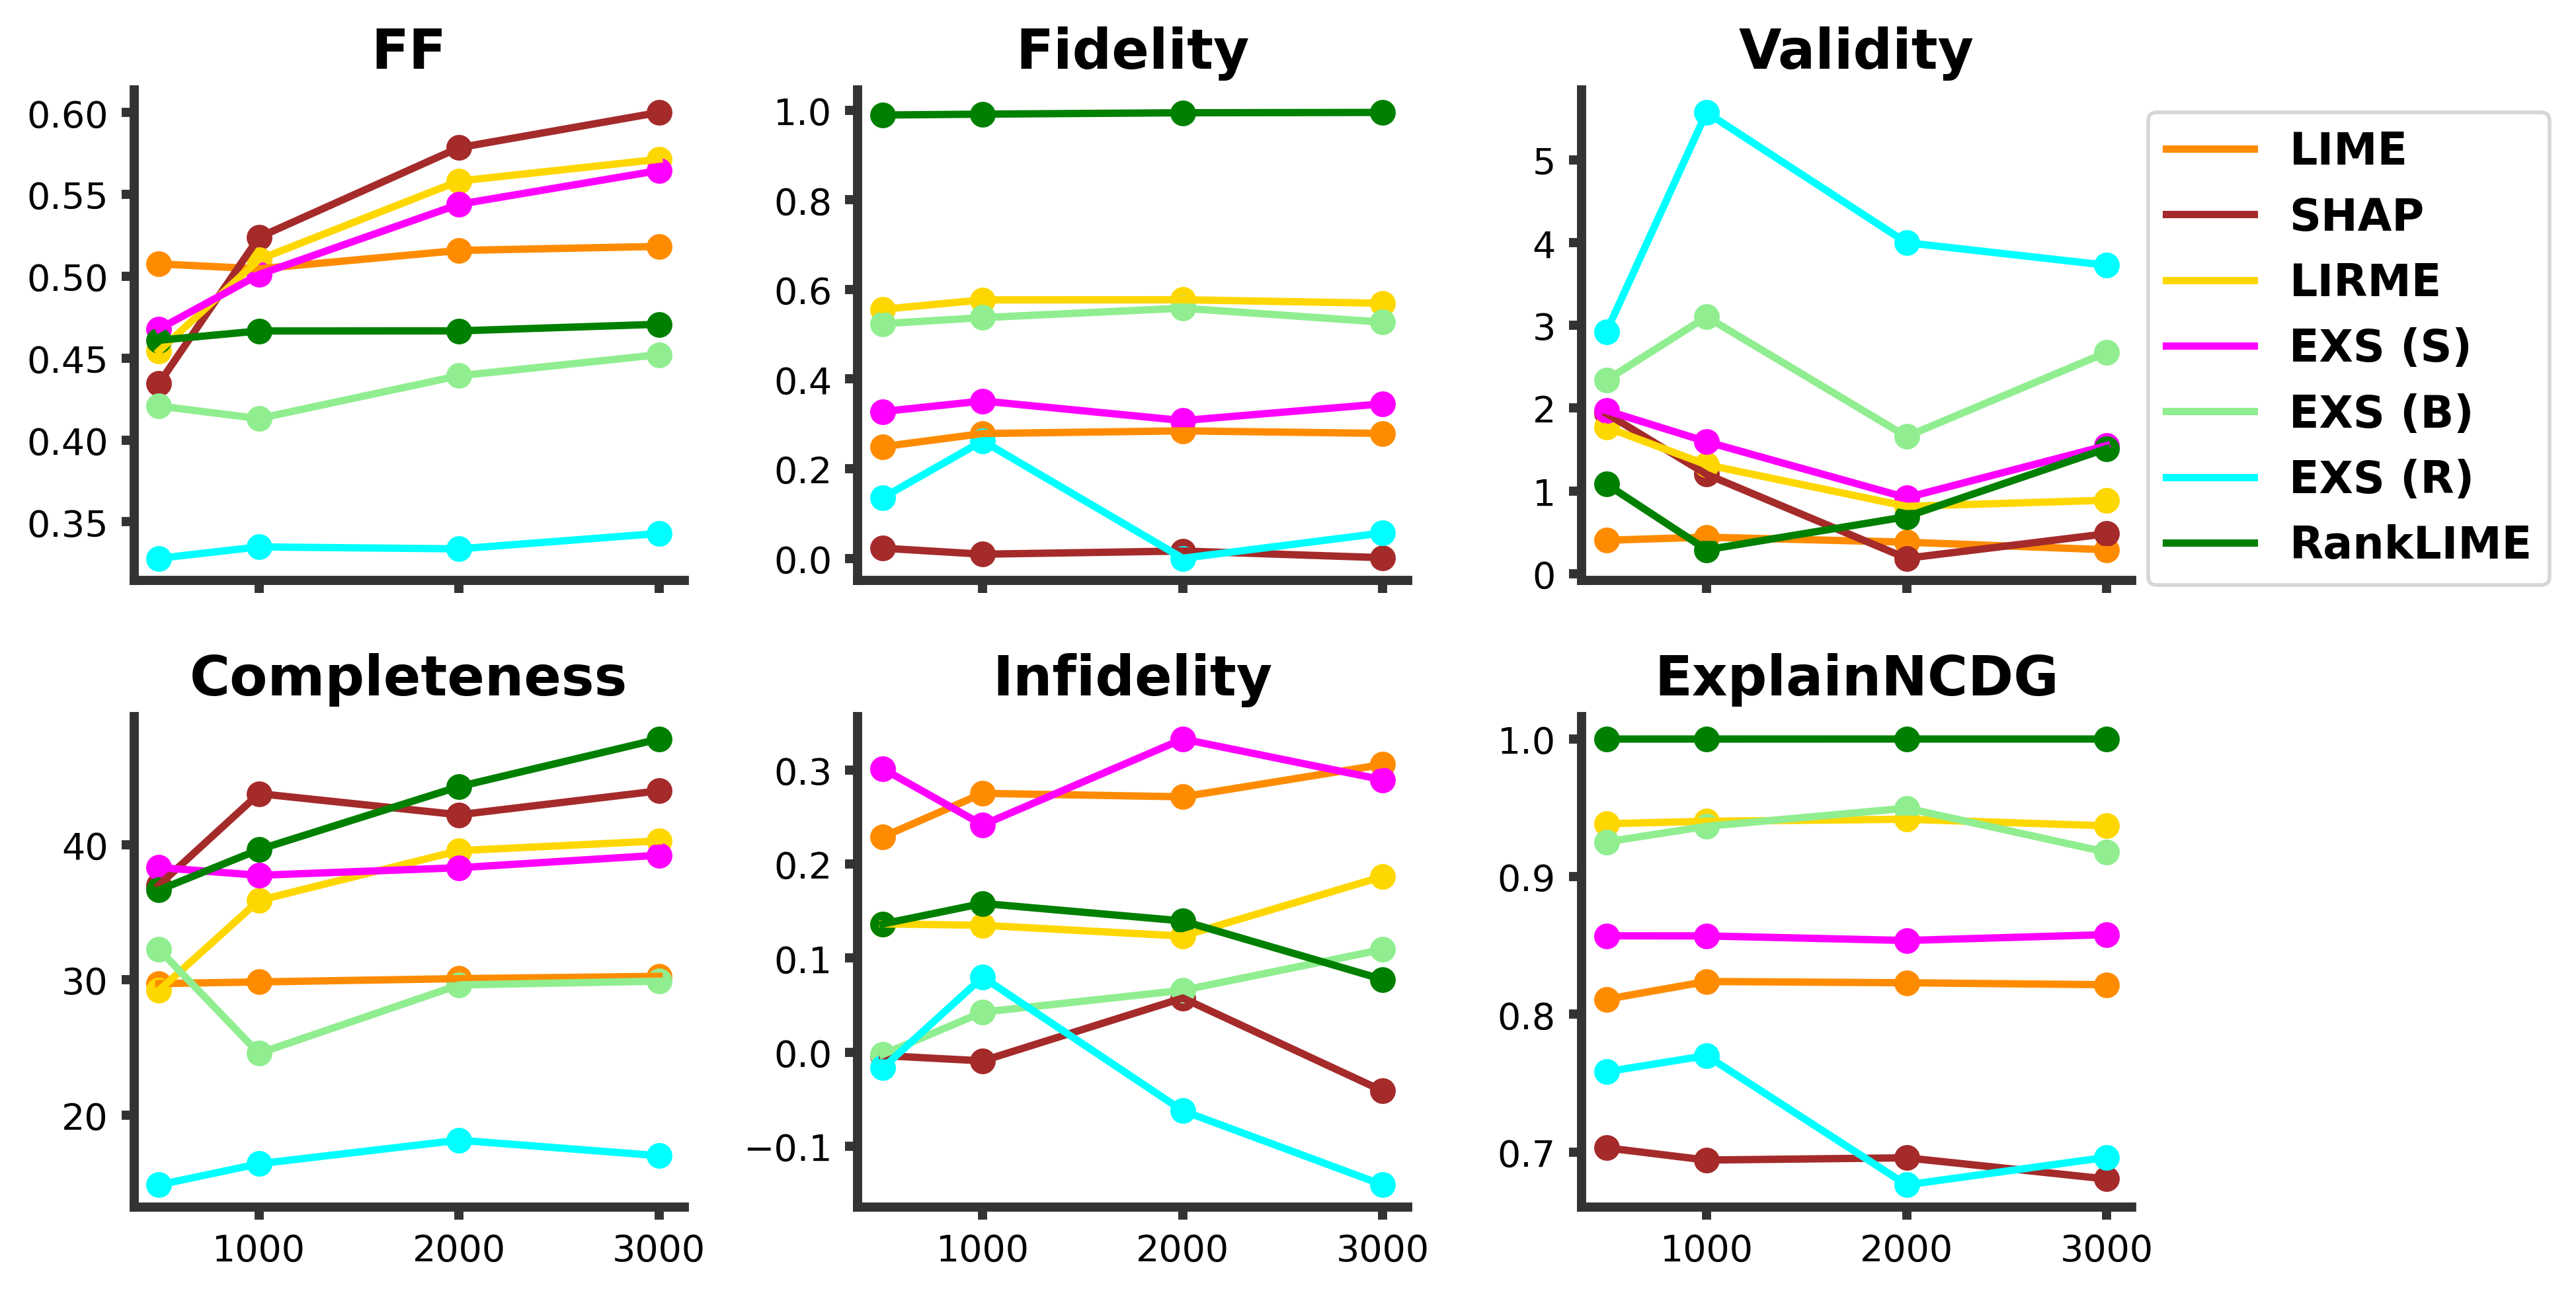

In [106]:
fig, ax = plt.subplots(2, 3, figsize=(10, 5), dpi=400, sharex=True)

measure_keys = ['dpff', 'fidelity_ltr', 'validity', 'completeness', 'infidelity', 'explain_ndcg']
measure_key_names = ['FF', 'Fidelity', 'Validity', 'Completeness', 'Infidelity', 'ExplainNCDG']
ax = ax.ravel()

e_listwise_sample_sizes = [400, 500, 700, 1000, 1500, 2000, 3000]
list_wise_selected_sample_size = [1, 3, 5, 6]

e_sample_sizes = [500, 1000, 1500, 2000, 3000, 4000, 5000]
point_wise_selected_sample_size = [0, 1, 3, 4]


for i in range(len(measure_keys)):
    m = measure_keys[i]
    for e in pointwise_exp: 
        s_result = []
        for j in range(len(point_wise_selected_sample_size)):
        #for j in range(len(result)):
            s_result.append(result[point_wise_selected_sample_size[j]].loc[e, measure_keys[i]])
        x_axis_ticks = np.array(e_sample_sizes)[point_wise_selected_sample_size]
        ax[i].plot(x_axis_ticks,s_result, label=exp_names_figure[e], c=color_list[e], linewidth=2)
        ax[i].scatter(x_axis_ticks,s_result, c=color_list[e])
        #ax[i].plot(e_sample_sizes,s_result, label=exp_names_figure[e], c=color_list[e], linewidth=2)
        #ax[i].scatter(e_sample_sizes,s_result, c=color_list[e])
        
        ax[i].set_title(measure_key_names[i], fontsize = 15, fontweight='bold')
        ax[i].set_xticklabels(x_axis_ticks)
    s_result = []
    for j in range(len(list_wise_selected_sample_size)):
        s_result.append(result_listwise[list_wise_selected_sample_size[j]].loc['rank_lime', measure_keys[i]])
    x_axis_ticks_2 = np.array(e_listwise_sample_sizes)[list_wise_selected_sample_size]
    ax[i].plot(x_axis_ticks_2, s_result, label=exp_names_figure['rank_lime'], c=color_list['rank_lime'], linewidth=2) 
    ax[i].scatter(x_axis_ticks_2, s_result,c=color_list['rank_lime']) 
    ax[i].set_xticklabels(x_axis_ticks_2)
    ax[i] = process_ax(ax[i])
ax[2].legend(loc='upper right', prop = {'weight':'bold', 'size':12}, bbox_to_anchor=(1.8, 1))
plt.tight_layout()
plt.savefig(f'./pointwise_sample_eval_agg_{DATASET_NAME}_v2.pdf')
plt.show()